# Hosting models on Grid

Grid offers both: Machine Learning as a Service and Encrypted Machine Learning as a service. In this series of tutorials we show how you can serve and query models on Grid.


### Use case: Skin cancer detection

Many people regularly check their skin for changes. Not all moles, patches, and rashes are cancerous. In this tutorial we'll train a model to differenciate between benign keratosis and melanoma (type of skin cancer).

Seborrheic keratosis is a noncancerous condition that can look a lot like melanoma. About 83 million Americans have seborrheic keratosis. About 5 percent of all new cancer cases in the United States are melanoma, a potentially deadly form of skin cancer. With prompt treatment, more than 91 percent of melanoma patients will survive 5 years or more after their first diagnosis. (Source: https://www.medicalnewstoday.com/articles/320742.php)


## 1. Train a model

The first thing we need is a model, we can train a model using **regular pytorch**! If you're familiar with pytorch feel free to skip this part of the tutorial.

Most of the code used in this part of the tutorial is actually at `helper.py` have a look at it if you want to know in more details what's going on in each subsection of this notebook.

### Dataset

We'll use this [kaggle dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/). You need to download this dataset before running this example.

We use the code available at [this kaggle kernel](https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing) by Kevin Mader and in [this tutorial](https://towardsdatascience.com/skin-cancer-classification-with-machine-learning-c9d3445b2163) by Nyla Pirani to preprocess the data.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.transforms as transforms

import helper

# Path where the data is stored. Change this if needed!
helper.DATASET_PATH

'./skin-cancer-mnist-ham10000'

**Read dataset**

In [2]:
df = helper.read_skin_cancer_dataset()

In [3]:
df['cell_type'].value_counts()

Melanoma                         1113
Benign keratosis-like lesions    1099
Name: cell_type, dtype: int64

**Visualize dataset**

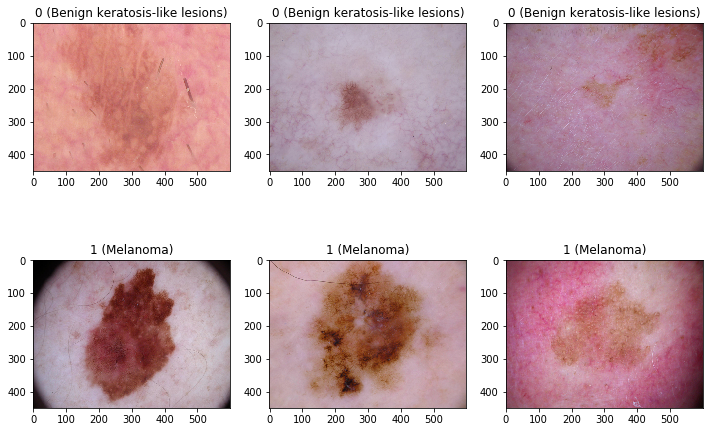

In [6]:
# Get samples from each class
samples = df.groupby('cell_type').apply(lambda x: x.sample(3))

# Plot samples
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2
for i in range(len(samples)):
    image = mpimg.imread(samples["path"].iloc[i])
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    title = "{} ({})".format(samples["cell_type_idx"].iloc[i], samples["cell_type"].iloc[i])
    plt.title(title)
plt.show()

### Prepare data for training

In [7]:
train_df, valid_df, test_df = helper.split_data(df)

In [8]:
# Parameters for the dataloader
input_size = 32
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 6}

# Calculate train_mean and train_std
training_set = helper.Dataset(train_df, transform=transforms.Compose([
                               transforms.Resize((input_size, input_size)),
                               transforms.ToTensor()]))
training_generator = torch.utils.data.DataLoader(training_set, **params)
train_mean, train_std = helper.calculate_mean_and_std(training_generator)

In [9]:
train_mean, train_std

(tensor([0.6979, 0.5445, 0.5735]), tensor([0.0959, 0.1187, 0.1365]))

In [10]:
# Create dataloaders
training_set = helper.Dataset(train_df, transform=helper.transform(input_size, train_mean, train_std))
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = helper.Dataset(valid_df, transform=helper.transform(input_size, train_mean, train_std))
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = helper.Dataset(test_df, transform=helper.transform(input_size, train_mean, train_std))
test_generator = torch.utils.data.DataLoader(test_set, **params)

### Model

In [11]:
model = helper.make_model()

In [12]:
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)

### Train Model

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [14]:
%%time
train_metrics, valid_metrics = helper.train(model, epochs=10, optimizer=optimizer,
                                            training_generator=training_generator,
                                            validation_generator=validation_generator)

Training loss at step 0 = 0.6986878514289856
Training loss at step 100 = 0.6462278962135315
Epoch: 0
Train
Average loss: 0.6698, Accuracy: 1007/1990 (50.6%)

Test
Average loss: 0.6730, Accuracy: 554/1106 (50.1%)

Training loss at step 200 = 0.6242784261703491
Epoch: 1
Train
Average loss: 0.6494, Accuracy: 1261/1990 (63.4%)

Test
Average loss: 0.6541, Accuracy: 683/1106 (61.8%)

Training loss at step 300 = 0.6444793939590454
Epoch: 2
Train
Average loss: 0.6365, Accuracy: 1305/1990 (65.6%)

Test
Average loss: 0.6451, Accuracy: 709/1106 (64.1%)

Training loss at step 400 = 0.5713369250297546
Epoch: 3
Train
Average loss: 0.6271, Accuracy: 1312/1990 (65.9%)

Test
Average loss: 0.6421, Accuracy: 719/1106 (65.0%)

Training loss at step 500 = 0.6071101427078247
Training loss at step 600 = 0.6496549844741821
Epoch: 4
Train
Average loss: 0.6628, Accuracy: 1234/1990 (62.0%)

Test
Average loss: 0.6744, Accuracy: 666/1106 (60.2%)

Training loss at step 700 = 0.7598112225532532
Epoch: 5
Train
Averag

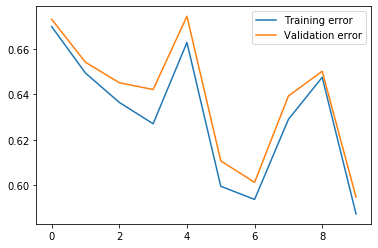

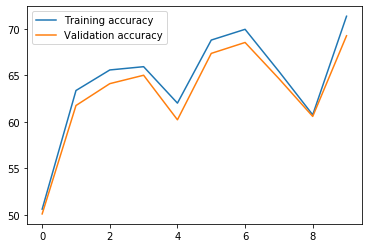

In [15]:
plt.plot([train_metric[0] for train_metric in train_metrics], label ='Training error')
plt.plot([valid_metric[0] for valid_metric in valid_metrics], label ='Validation error')
plt.legend()
plt.show()
plt.plot([train_metric[1] for train_metric in train_metrics], label ='Training accuracy')
plt.plot([valid_metric[1] for valid_metric in valid_metrics], label ='Validation accuracy')
plt.legend()
plt.show()

### Evaluate model

In [19]:
helper.test(model, test_generator)

Average loss: 0.5849, Accuracy: 797/1106 (72.1%)



(0.584854376898105, 72.0614828209765)

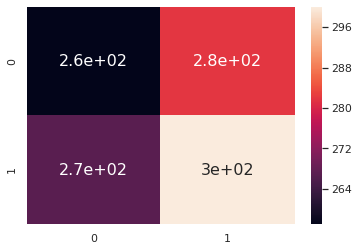

In [17]:
helper.plot_confusion_matrix(model, test_generator)

Let's save the model so we can load it for our next step.

In [18]:
torch.save(model.state_dict(), "binary-skin-cancer-detection-model")

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

## Star PySyft on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool tools we're building.

[Star PySyft](https://github.com/OpenMined/PySyft)

## Join our Slack!
The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at http://slack.openmined.org

## Join a Code Project!
The best way to contribute to our community is to become a code contributor! At any time you can go to PySyft GitHub Issues page and filter for "Projects". This will show you all the top level Tickets giving an overview of what projects you can join! If you don't want to join a project, but you would like to do a bit of coding, you can also look for more "one off" mini-projects by searching for GitHub issues marked "good first issue".

[PySyft Projects](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3AProject)
[Good First Issue Tickets](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)

## Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)